# Simple Bigram language model
### Trained with counts and neural net

- A bigram language model uses a token to predict the next token.
- Context window is only one token wide.
- It is simple to implement using just a lookup table.
- Generally considered inferior to other models.
- This implementation will be a character language model, i.e., given a character, it will predict the next character in the sequence.

In [5]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

### Load 'names.txt' Dataset

In [6]:
names = open('names.txt', 'r').read().splitlines()
print(f"Total Names: {len(names)}", *names[:5], "...", sep=", ")

Total Names: 32033, emma, olivia, ava, isabella, sophia, ...


## Prediction with bigram counts method
### Creating count matrix

In [7]:
N = torch.zeros((27, 27), dtype=torch.int32)

### Dictionaries to convert characters to int and back

In [8]:
ctoi = {c:i for i, c in enumerate(['.'] + sorted(list(set(''.join(names)))))}
itoc = {i:c for c, i in ctoi.items()}

### Fill count matrix

In [9]:
for name in names:
    for a, b in zip('.' + name, name + '.'):
        N[ctoi[a], ctoi[b]] += 1

### Visualise count matrix

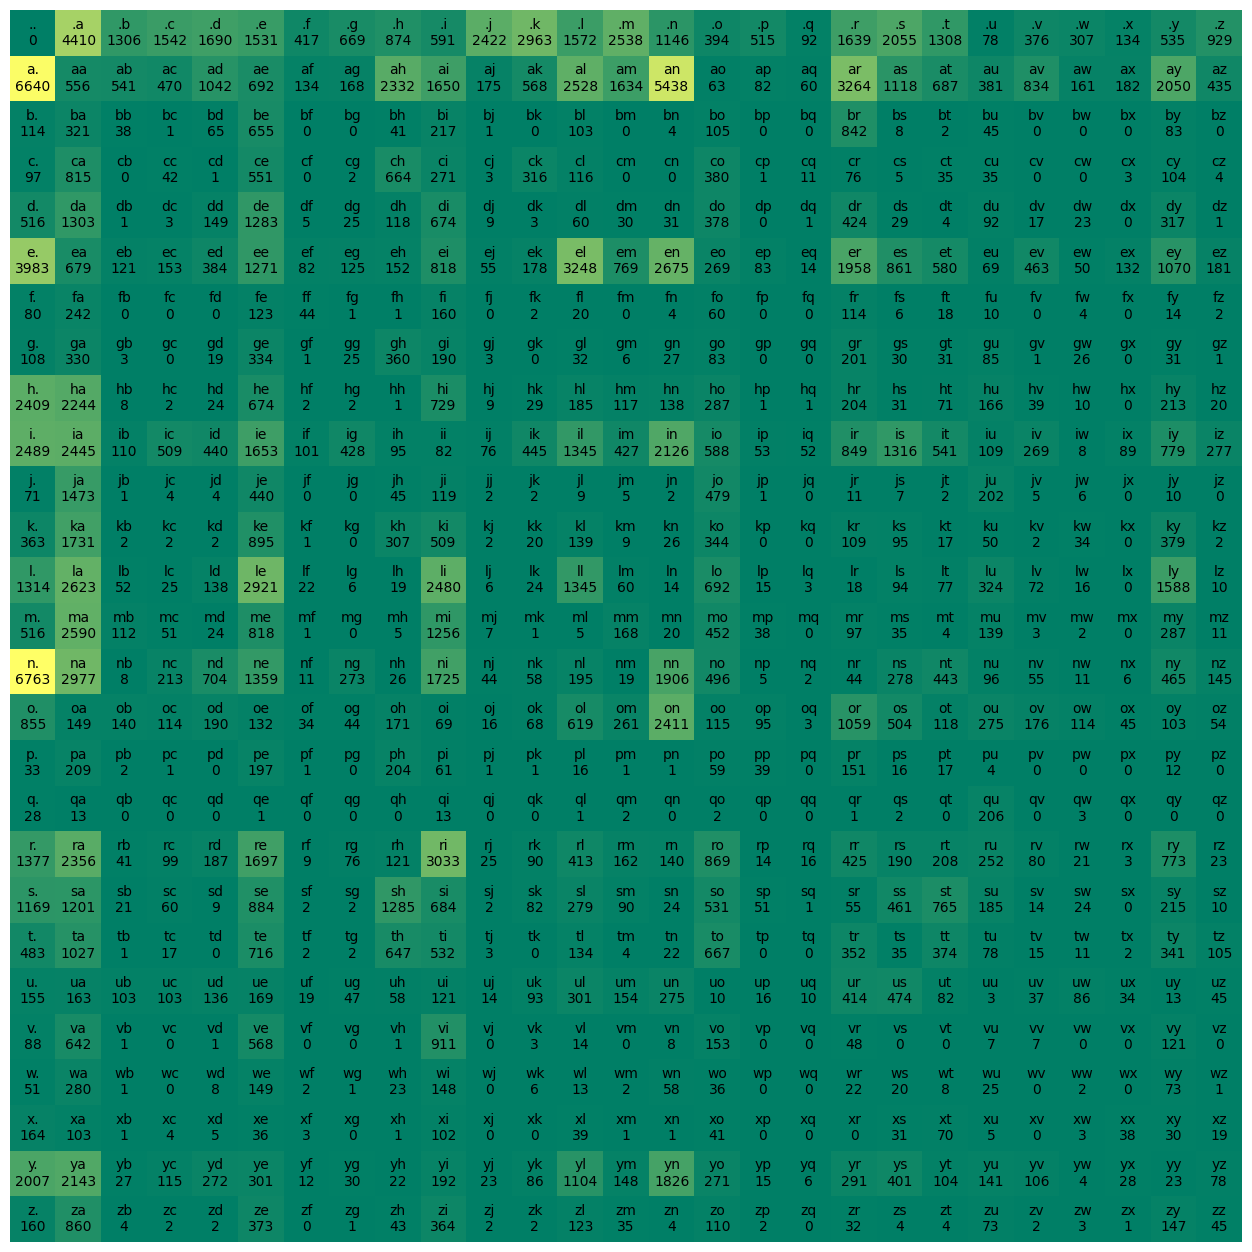

In [10]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='summer')
labels = [[plt.text(j, i, f"{itoc[i] + itoc[j]}\n{N[i, j]}", ha='center', va = 'center') for j in range(27)] for i in range(27)]
plt.axis('off')
plt.show()

### Apply Smoothening
A constant value is added to all counts, to avoid the model from ruling out certain predictions, not present in training dataset.

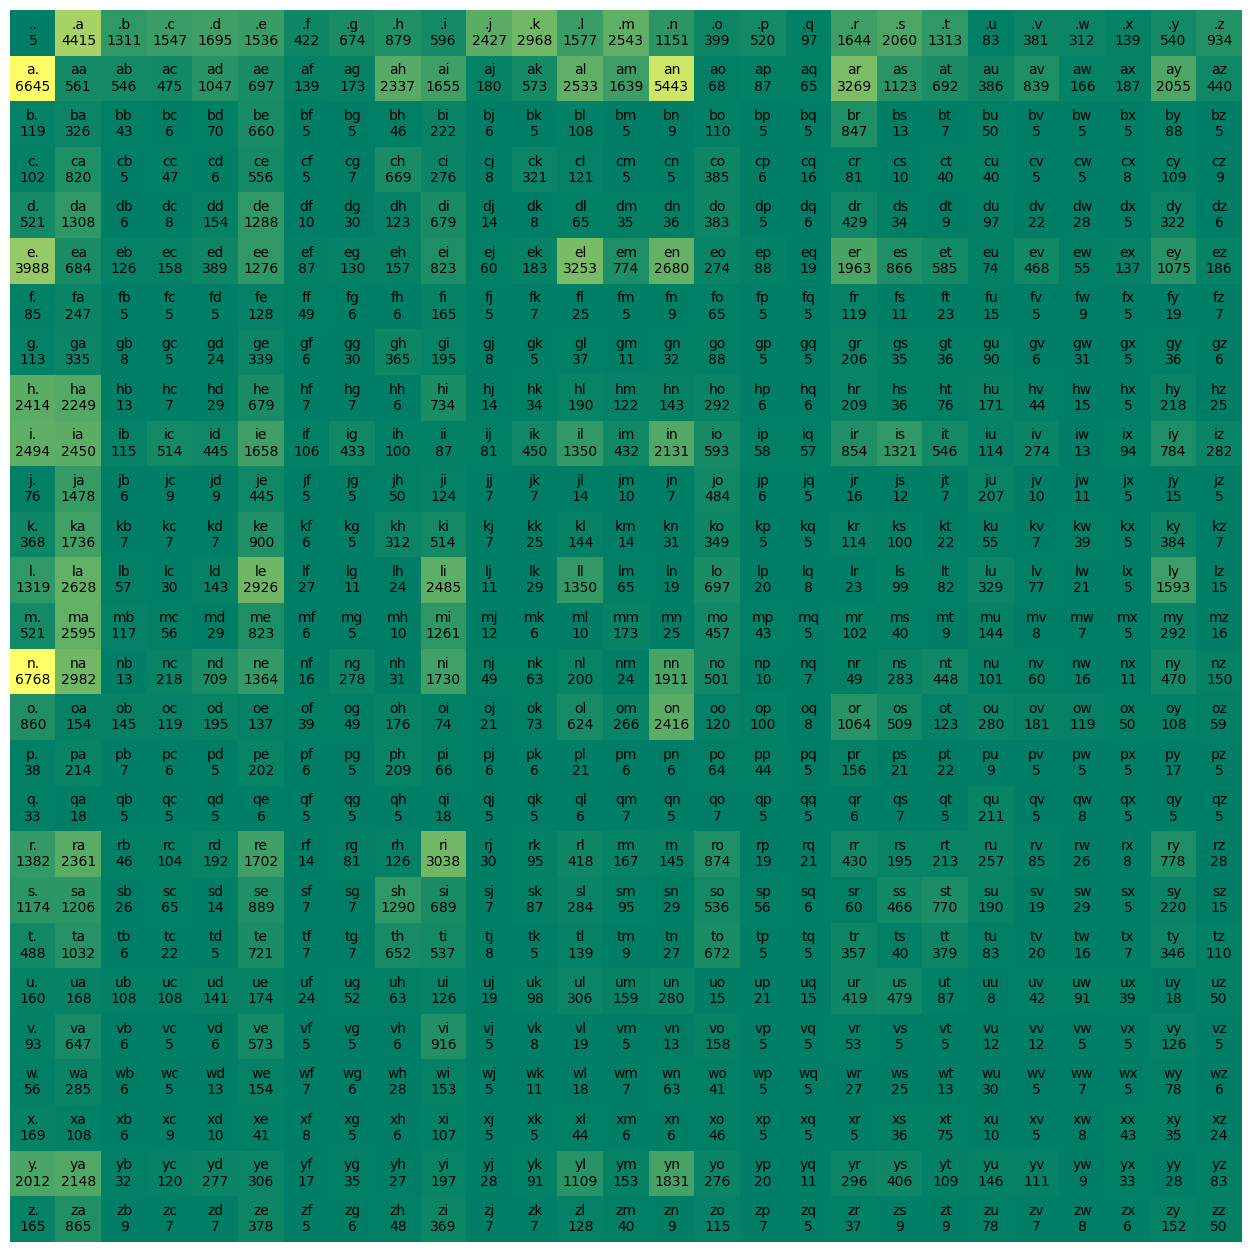

In [18]:
sm = 5
N_smooth = (N+sm)
plt.figure(figsize=(16,16))
plt.imshow(N_smooth, cmap='summer')
labels = [[plt.text(j, i, f"{itoc[i] + itoc[j]}\n{N_smooth[i, j]}", ha='center', va = 'center') for j in range(27)] for i in range(27)]
plt.axis('off')
plt.show()

### Create Probability matrix

In [19]:
P = (N_smooth).float()
P /= P.sum(1, keepdim=True)

### Generate word using probabilities
The Probability matrix, given any character c1, can tell us what are the probabilities of the next character being c2, using simple lookup `P[c1, c2]`

For Generation, `torch.multinomial` takes an array as an input, and chooses one index from the array depending on the probabilities provided to it through the array

In [34]:
def generateWord():
    c = '.'
    word = ''
    while True:
        i = ctoi[c]
        pred = torch.multinomial(P[i, :], num_samples=1, replacement=True).item()
        if pred == 0: break
        c = itoc[pred]; word += c
    return word

print("Names Generated:", [generateWord() for _ in range(5)])

Names Generated: ['yl', 'miawriazar', 'karshila', 'zamesoahma', 'xbr']


### Using NLL to find loss
NLL: Negative Log Likelyhood
Given an input `c1`, an output `c2`, and a probability matrix `P`, `NLL = -P[c1, c2].log()`

This gives us a good loss function, which gives us an estimate of how close our matrix P is to the dataset, or Ground truth
It is normalised to get a sense of magnitude regardless of size of dataset.

In [36]:
log_likelihood = 0.0
n = 0
for name in names:
    for a, b in zip('.' + name, name + '.'):
        ix1, ix2 = ctoi[a], ctoi[b]
        prob = P[ix1, ix2]
        logprob = prob.log()
        log_likelihood += logprob
        n += 1
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'Normalised NLL: {nll/n}')

log_likelihood=tensor(-560645.1875)
nll=tensor(560645.1875)
Normalised NLL: 2.4573965072631836


### Neural Network Method
Creating arrays `xs`and `ys` to store inputs and expected outputs for the model, respectively

In [38]:
xs = []
ys = []

for name in names:
    for a, b in zip('.' + name, name + '.'):
        idx1, idx2 = ctoi[a], ctoi[b]
        xs.append(idx1); ys.append(idx2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f"Total examples: {num}")

Total examples: 228146


### Initialise a 27 x 27 weights matrix `W`

In [40]:
W = torch.randn((27, 27), requires_grad=True)

### Training over 100 iterations
Inputs are one-hot encoded. It means, given an input 3 with a class size of 5, one-hot encoding will be: [0, 0, 0, 1, 0]

`logits` defines the log of probabilities of outputs.

When encoded input `c1` is cross-multiplied with weights 'W' , we should obtain probabilities of what `c2` , the character following `c1` could be.

`logits` is exponentiated to convert log into counts.

`loss` is devied as the normalised NLL of the probabilities

Smoothening is performed on `loss` by adding a factor multiplied by mean squares of the weights. The farther away weights are from zero, higher the loss. This adds a tendency to the model to equalise all the weights.

In [42]:
for k in range(100):
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    prob = counts / counts.sum(1, keepdim=True)
    loss = -prob[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean()
    print(f"Itr {k}: Loss: {loss.item()}")
    W.grad = None
    loss.backward()

    W.data += -50*W.grad

Itr 0: Loss: 2.5207364559173584
Itr 1: Loss: 2.519379138946533
Itr 2: Loss: 2.5180888175964355
Itr 3: Loss: 2.516860008239746
Itr 4: Loss: 2.5156893730163574
Itr 5: Loss: 2.514573574066162
Itr 6: Loss: 2.513507843017578
Itr 7: Loss: 2.5124902725219727
Itr 8: Loss: 2.5115180015563965
Itr 9: Loss: 2.510587453842163
Itr 10: Loss: 2.509697198867798
Itr 11: Loss: 2.5088441371917725
Itr 12: Loss: 2.5080270767211914
Itr 13: Loss: 2.5072433948516846
Itr 14: Loss: 2.50649094581604
Itr 15: Loss: 2.5057690143585205
Itr 16: Loss: 2.505075216293335
Itr 17: Loss: 2.504408597946167
Itr 18: Loss: 2.5037670135498047
Itr 19: Loss: 2.503150463104248
Itr 20: Loss: 2.502556324005127
Itr 21: Loss: 2.5019848346710205
Itr 22: Loss: 2.5014333724975586
Itr 23: Loss: 2.5009024143218994
Itr 24: Loss: 2.500389814376831
Itr 25: Loss: 2.4998958110809326
Itr 26: Loss: 2.4994187355041504
Itr 27: Loss: 2.498957872390747
Itr 28: Loss: 2.4985132217407227
Itr 29: Loss: 2.498082399368286
Itr 30: Loss: 2.497666835784912
Itr

### Results
A loss of ~ 2.48 was obtained, which is close enough to 2.45, which is what we got from the counts matrix. Neural Net approach to solve this problem is much more scalable. As the context window increase from 2 to 3, 4, and so on, the size of our counts matrix will grow exponentially, and due to the dataset being limited, almost all of the cells will be filled with zeroes. this will negatively affect the model's response.

### Generating sample names from the NeuralNet
- Initialise `idx` to 0 [Starting Character]
- One-Hot Encode `idx`
- Calculate logits, counts and probabilities
- Pick next idx using multinomial distribution function
    - If `idx` is 0, stop
    - Else, print character `idx` and continue

In [44]:
for i in range(5):
    idx = 0
    while True:
        xenc = F.one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        prob = counts / counts.sum(1, keepdim=True)
        idx = torch.multinomial(prob, num_samples=1, replacement=True)
        if idx == 0: break
        print(itoc[idx.item()], end='')
    print()

za
jathlilrndade
sele
mrifbraca
llanelene


### Conclusion
Implemented bigram language model using count matrix and neural network methods. 

Bigram language model does not provide very accurate results due to its context window being very small.